# Computational Fourier Optics

This notebook provides a few code gists from *Computational Fourier Optics* by David Voeltz, SPIE, 2011.


In [210]:
import numpy as np
import pandas as pd
import pyradi.ryplot as ryplot
from matplotlib import cm
from scipy import interpolate

%matplotlib inline

In [53]:
# to determine the wavefront from seidel coefficients
# book page 144

def seidel_5(u0,v0,X,Y,wd,w040,w131,w222,w220,w311):
    """Compute wavefront OPD for first 5 Seidel aberration coeff + defocus
    
    u0,v0 - normalized image plane coordinate 
    X,Y - normalized pupil coordinate arrays (like from meshgrid)

    wd-defocus 
    w040-spherical 
    w131-coma
    w222-astigmatism 
    w220-field curvature
    w311-distortion
    """
    
    beta=np.arctan2(v0,u0) # angle
    u0r=np.sqrt(u0**2+v0**2) # height
    # rotate grid
    Xr = X * np.cos(beta) + Y * np.sin(beta)
    Yr =-X * np.sin(beta) + Y * np.cos(beta)

    # Seidel polynomials
    rho2 = Xr**2 + Yr**2
    w =  wd * rho2 
    w += w040 * rho2**2
    w += w131 * u0r * rho2 * Xr  
    w += w222 * u0r**2 * Xr**2 
    w += w220 * u0r**2 * rho2 
    w += w311 * u0r**3 * Xr

    return w


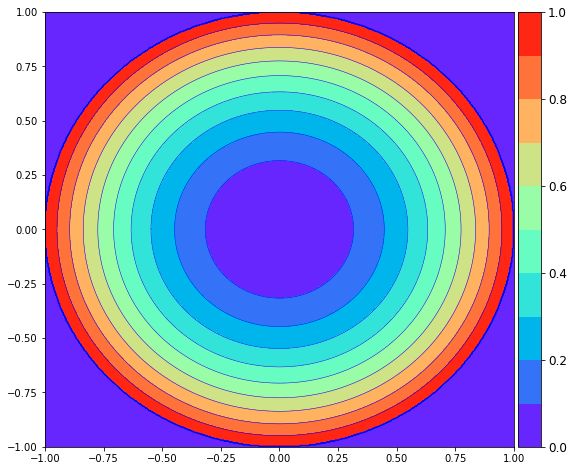

In [54]:
u0 = 1
v0 = 0
wd = 0   # defocus
w040 = 0 # spherical 
w131 = 0 # coma
w222 = 0 # astigmatism
w220 = 1 # field curvature
w311 = 0 # distortion

n = 500 

x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X,Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
w = seidel_5(u0,v0,X,Y,wd,w040,w131,w222,w220,w311)
w = np.where(R<=1,w,0)  # nann does not work with plot_surface
p = ryplot.Plotter(1,1,2,figsize=(20,8))
# p.mesh3D(1,X,Y,w)
p.meshContour(2,X,Y,w,cbarshow=True);


1024 samples over 0.001 m in image plane, sample interval is 9.765625e-07 m
Image plane: umin=-0.0005 umax=0.000499023437500001


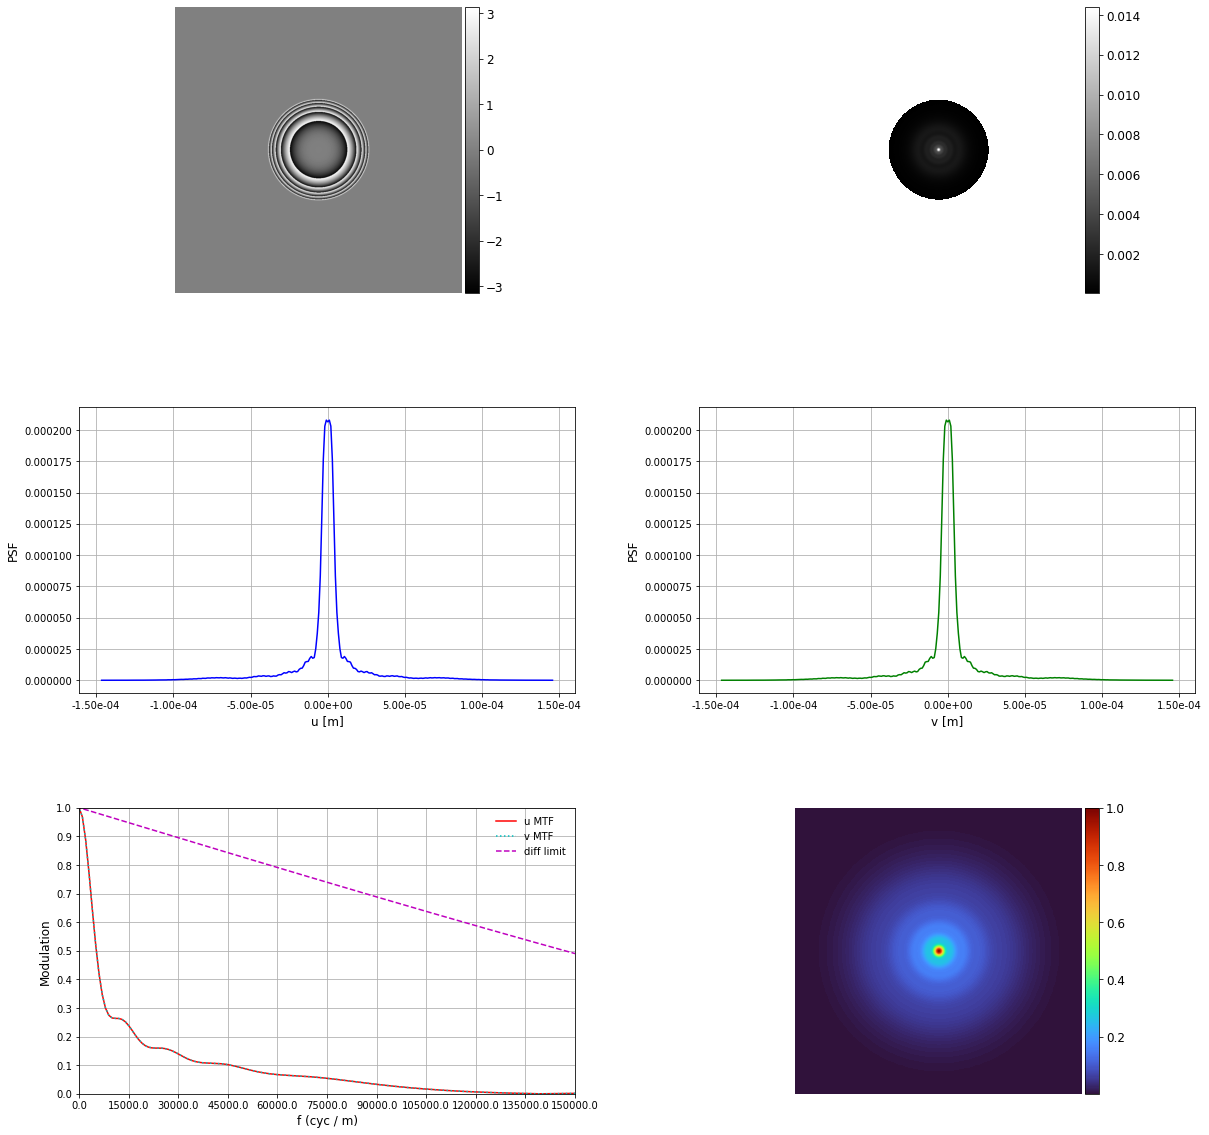

In [220]:
# book page 148

# lens_psfmtf
# f / 5 plano-convex lens (Newport lens KPX094)
# focal length 100 mm
# 10 mm image height
# psf and mtf with Seidel aberrations
# aberration coefficients from ZEMAX

M = 1024 # number samples 
msize = 150  # for limiting display 
mmin = np.int(M/2 - msize)
mmax = np.int(M/2 + msize)

L = 1e-3   # [m] image plane size
du = L / M # [m] image plane spatial sample interval

#image plane coordinates
u = np.arange(-L/2,+L/2,du)
v = np.arange(-L/2,+L/2,du) 
U,V = np.meshgrid(u,v)
RUV = np.sqrt(U**2 + V**2)

wavelen = 0.55e-6 
diaPupil = 20e-3
radPupil = diaPupil / 2 
focalLen = 100e-3                # exit pupil distance
fnum = focalLen / (2 * radPupil) # exit pupil f-number
lz = wavelen * focalLen
cutoffFreq = 1 / (wavelen * fnum)     # incoh cutoff freq

print(f'{M} samples over {L} m in image plane, sample interval is {du} m')
print(f'Image plane: umin={np.min(u)} umax={np.max(u)}')

#normalized image coordinate
u0 = 0 
v0 = 0

# aberration coefficients
wd = 0 * wavelen
w040 = 4.963 * wavelen
w131 = 2.637 * wavelen
w222 = 9.025 * wavelen
w220 = 7.536 * wavelen
w311 = 0.157 * wavelen

p = ryplot.Plotter(1,3,2,figsize=(20,20))

# image freq coords
fu = np.arange(-1 / (2 * du), 1 / (2 * du), 1 / L)
Fu, Fv = np.meshgrid(fu,fu)
R = np.sqrt(Fu**2 + Fv**2)

# # wavefront
W = seidel_5(u0,v0,-Fu*(lz/radPupil),-Fv*(lz/radPupil),wd,w040,w131,w222,w220,w311)

# # coherent transfer function
H = np.exp(-1j * (2 * np.pi / wavelen) * W)
H = np.where(R*lz/radPupil<=1,H,0)

# point spread function
h2 = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H))))**2
# h2 = h2 / np.max(h2)

# # MTF
MTF = np.abs(np.fft.fft2(np.fft.fftshift(h2)))
MTF = MTF / MTF[0,0] #normalize DC to 1
MTF = np.fft.ifftshift(MTF)

# analytic MTF.  ugly clutch necessary to have valid arccos and sqrt
futwof0 = np.where(fu / cutoffFreq>0.9999,0.9999,fu / cutoffFreq)
futwof0 = np.where(futwof0<-0.9999,-0.9999,futwof0)
MTF_an = (2 / np.pi) * (np.arccos(futwof0)-(futwof0) * np.sqrt(1-(futwof0)**2))
MTF_an = np.where(fu/(2*cutoffFreq)<1,MTF_an,np.nan)

p.showImage(1,np.angle(H),xlabel='--',ylabel='--',cbarshow=True);
# p.meshContour(1,U,V,np.angle(H),meshCmap=cm.gray,cbarshow=True,xlabel='u (m)',ylabel='v (m)');
# p.getSubPlot(1).axis('equal')
p.showImage(2,np.sqrt(np.where(R*lz/radPupil<=1,h2,np.nan)),xlabel='--',ylabel='--',cbarshow=True);
# p.meshContour(2,U,V,np.sqrt(np.where(R*lz/radPupil<=1,h2,np.nan)),meshCmap=cm.gray,cbarshow=True,xlabel='u (m)',ylabel='v (m)');
# p.getSubPlot(2).axis('equal')
p.plot(3,u[mmin:mmax],h2[int(M/2),mmin:mmax],'','u [m]','PSF',maxNX=7,xAxisFmt='%.2e')
p.plot(4,u[mmin:mmax],h2[mmin:mmax,int(M/2)],'','v [m]','PSF',maxNX=7,xAxisFmt='%.2e')
p.plot(5,fu,MTF[int(M/2),:],label=['u MTF'])
p.plot(5,fu,MTF[:,int(M/2)],linestyle=[':'],label=['v MTF'])
p.plot(5,fu,MTF_an,'','f (cyc / m)','Modulation',linestyle=['--'],label=['diff limit'],pltaxis=[0,150000,0,1])
p.showImage(6,MTF[mmin:mmax,mmin:mmax],xlabel='--',ylabel='--',cmap='turbo',cbarshow=True);
# p.meshContour(6,Fu,Fv,MTF,meshCmap=cm.jet,cbarshow=True,levels=40,xlabel='--',ylabel='--');
# p.getSubPlot(6).axis('equal')


This work is not in the Voeltz book. The requirement is to calculate the point spread function from a given MTF curve.
Only a single curve is available, as measured by Griffith and Magidamishi at 770 nm. Presumably this is the on-axis MTF, and applies to all rotational planes in the system (sagittal, tangential, and all others in between).

![](../scanplot/Qioptic6_50000_770nm_MTF_result.png)

In the analysis below the \ac{PSF} is calculated for eventual use with a particular pixel size, 5.3~\si{\micro\metre}.  This \ac{PSF} must be provided such that each sensor pixel is determined by convolution of a 3x3 higher resolution image with pixel size of 5.3/3~\si{\micro\metre}.  In order to calculate each of these smaller pixel values accurately, they are further subdivided in to even smaller pixels, three times smaller.  The values in these nine-times-smaller pixels are added in batches of 3x3 to get to the 5.3/3~\si{\micro\metre} pixel size.

In [221]:
dfQmtf = pd.read_csv('data/Qioptic6_50000_770nm_MTF.txt',sep=' ', names=['Freq cy/mm','MTF'])
dfQmtf['Freq cy/m'] = 1000 * dfQmtf['Freq cy/mm'] 
f = interpolate.interp1d(dfQmtf['Freq cy/m'], dfQmtf['MTF'],bounds_error=False,fill_value=0)


In [273]:
M = 1024 # number samples 
msize = 150  # for MTF display
mmin = np.int(M/2 - msize)
mmax = np.int(M/2 + msize)
psize = 20  # for psf display
pmin = np.int(M/2 - psize)
pmax = np.int(M/2 + psize)
du = 5.3e-6 / 9 # [m] step size in image plane
L = du * M # [m] image size

# image freq coords
fu = np.arange(-1 / (2 * du), 1 / (2 * du), 1 / L)
Fu, Fv = np.meshgrid(fu,fu)
R = np.sqrt(Fu**2 + Fv**2)

#image plane coordinates
u = np.arange(-L/2,+L/2,du)
v = np.arange(-L/2,+L/2,du) 
U,V = np.meshgrid(u,v)
RUV = np.sqrt(U**2 + V**2)

MTF = f(R)
MTF = MTF / np.max(MTF)
psf = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(MTF))))
psf = psf/ np.max(psf)

In [333]:
# https://stackoverflow.com/questions/21220942/sums-of-subarrays
def sub_sums(arr, nrows, ncols):
    h, w = arr.shape
    h = (h // nrows)*nrows 
    w = (w // ncols)*ncols 
    arr = arr[0:h,0:w]
    return np.einsum('ijkl->ik', arr.reshape(h // nrows, nrows, -1, ncols))

Us = U[2::3,2::3]
Vs = V[2::3,2::3]
psf3 = sub_sums(psf, 3, 3)

ssize = 3  # for subsampled PSF
smin = int(M / 6 +0.5 - ssize)
smax = int(M / 6 +0.5 + ssize) - 1
psf4 = psf3[smin:smax,smin:smax]
psf4 = psf4 / np.sum(psf4)
print(np.sum(psf4))
print(psf4)

core = psf4[1:4,1:4]
print(f'Pixel ensquared energy is {100*np.sum(core)/np.sum(psf4):.1f}% for 5.3 um pixel')
with open('zacube2.dat','w') as fout:
    fout.write('5 5 \n')
    np.savetxt(fout, psf4, fmt="%.6f")

1.0
[[0.00492497 0.00811633 0.01280909 0.01150333 0.00679768]
 [0.00811633 0.02865494 0.06184526 0.05295197 0.01869888]
 [0.01280909 0.06184526 0.13559729 0.11494322 0.03884933]
 [0.01150333 0.05295197 0.11494322 0.0983274  0.03330056]
 [0.00679768 0.01869888 0.03884933 0.03330056 0.0128641 ]]
Pixel ensquared energy is 72.2% for 5.3 um pixel


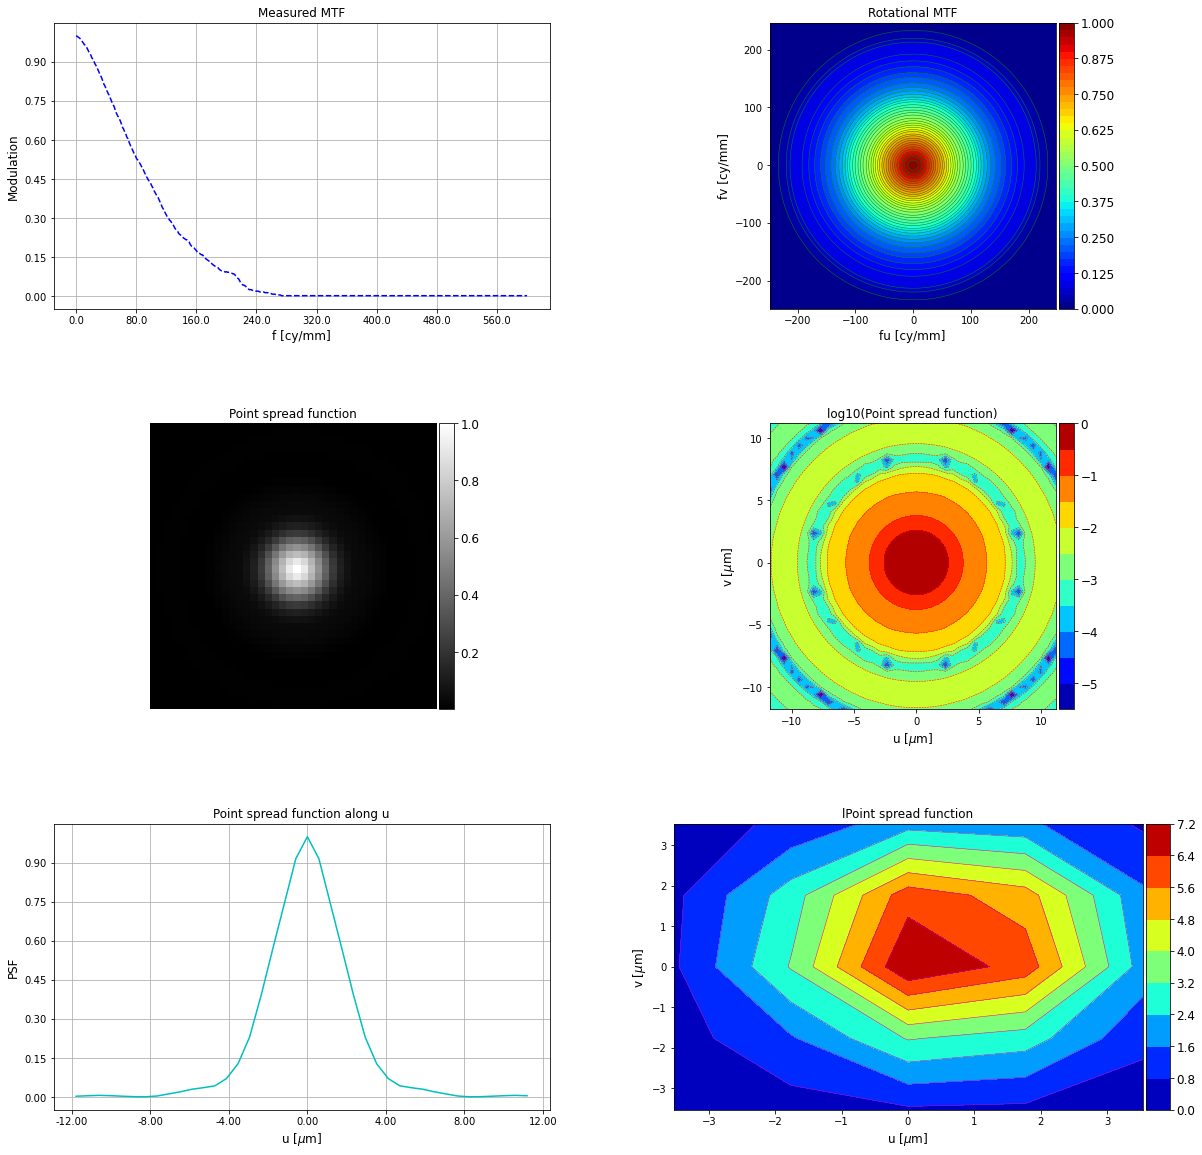

In [318]:

p = ryplot.Plotter(1,3,2,figsize=(20,20))
p.plot(1,dfQmtf['Freq cy/m']/1000,dfQmtf['MTF'],'Measured MTF','f [cy/mm]','Modulation',linestyle=['--'])#,pltaxis=[0,300000,0,1])
# p.showImage(2,MTF[mmin:mmax,mmin:mmax],xlabel='--',ylabel='--',cmap='turbo',cbarshow=True);
p.meshContour(2,Fu[mmin:mmax,mmin:mmax]/1000,Fv[mmin:mmax,mmin:mmax]/1000,MTF[mmin:mmax,mmin:mmax],
              ptitle='Rotational MTF',meshCmap=cm.jet,cbarshow=True,levels=40,xlabel='fu [cy/mm]',ylabel='fv [cy/mm]');
p.getSubPlot(2).axis('equal')
p.showImage(3,psf[pmin:pmax,pmin:pmax],ptitle='Point spread function',xlabel='u [m]',ylabel='v [m]',cbarshow=True);
p.meshContour(4,U[pmin:pmax,pmin:pmax]/1e-6,V[pmin:pmax,pmin:pmax]/1e-6,np.log10(psf[pmin:pmax,pmin:pmax]),
              ptitle='log10(Point spread function)', xlabel='u [$\mu$m]', ylabel='v [$\mu$m]',
              meshCmap=cm.jet,cbarshow=True);
p.getSubPlot(4).axis('equal');
p.plot(5,u[pmin:pmax]/1e-6,psf[int(M/2),pmin:pmax],'Point spread function along u','u [$\mu$m]','PSF',maxNX=7,xAxisFmt='%.2f')
p.meshContour(6,Us[smin:smax,smin:smax]/1e-6,Vs[smin:smax,smin:smax]/1e-6,psf3[smin:smax,smin:smax],
              ptitle='lPoint spread function', xlabel='u [$\mu$m]', ylabel='v [$\mu$m]',
              meshCmap=cm.jet,cbarshow=True);


In [280]:


psf3 = sub_sums(psf, 3, 3)
print(psf.shape)
print(psf3.shape)


(1024, 1024)
(341, 341)


In [ ]:
# # MTF
MTF = np.fft.ifftshift(np.abs(np.fft.fft2(np.fft.fftshift(h2))))
